# CO460 - Deep Learning - Tutorial 3

## Introduction

In this tutorial, there are two parts:

First:
- A simple single layer autoencoder (AE) 
- A simple variational autoencoder (VAE)

Second:
- Exercise and experimentations with Convolutional AE's
- Exercise and experimentations with Convolutional VAE's

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from utils import *
import matplotlib.pyplot as plt
import numpy as np

### Device selection

In [16]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [3]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

## Part I - Autoencoders

###  Normalization: 

$ x_{norm} = \frac{x-\mu}{\sigma} $

_Thus_ :
$ \min{x_{norm}} = \frac{\min{(x)}-\mu}{\sigma} = \frac{0-0.5}{0.5} = -1 $

_Similarly_:

$ \max{(x_{norm})} = ... = 1 $

* Input before normalization for MNIST dataset $\in [0,1]$
* Input after normalization $\in [-1,1] $
* Output should span the same interval $ \rightarrow$ Activation function of the output layer should be chosen carfeully (which one should we be using here?)

In [4]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

denorm = denorm_for_tanh

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("./data/", train=False, transform=transform)

### Hyper-parameter selection

In [5]:
if not os.path.exists('./single_layer_AE'):
    os.mkdir('./single_layer_AE')
    
num_epochs = 5
batch_size = 128
learning_rate = 1e-3
latent_dim = 32

### Define the dataloaders

In [6]:
train_loader = DataLoader(train_dat, batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dat, batch_size, shuffle=False, num_workers=16)

it = iter(test_loader)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[:32, :, :, :]

in_dim = fixed_input.shape[-1] * fixed_input.shape[-2]

save_image(fixed_input, './single_layer_AE/image_original.png')

### Define the model

#### Single layer AE structure

<img src="imgs/single_layer_AE.png" width="300" />

In [7]:
class AE_single(nn.Module):
    def __init__(self, in_dim=784, h_dim=32):
        super(AE_single, self).__init__()

        self.encoder = nn.Linear(in_dim, h_dim)

        self.decoder = nn.Sequential(
            nn.Linear(h_dim, in_dim),
            nn.Tanh()
            )
        
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

In [8]:
single_layer_AE = AE_single(h_dim=latent_dim)

### Define Loss function

In [9]:
criterion = nn.L1Loss(reduction='sum')  # can we use any other loss here?
def loss_function_AE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [10]:
model = single_layer_AE.to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))  # what would the number actually be
print(model)

Total number of parameters is: 50992
AE_single(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Tanh()
  )
)


### Choose and initialize optimizer

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 ### Train

In [12]:
model.train()

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_AE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader.dataset)))
    recon = model(fixed_input.view(fixed_input.size(0), -1).to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './single_layer_AE/reconstructed_epoch_{}.png'.format(epoch))
    # save the model
    torch.save(model.state_dict(), './single_layer_AE/model.pth')

epoch [1/10], loss:180.3450
epoch [2/10], loss:109.9410
epoch [3/10], loss:91.3170
epoch [4/10], loss:80.7935
epoch [5/10], loss:71.9341
epoch [6/10], loss:64.8662
epoch [7/10], loss:59.5558
epoch [8/10], loss:56.8668
epoch [9/10], loss:54.2761
epoch [10/10], loss:51.6723


### Test

In [13]:
# load the model
model.load_state_dict(torch.load("./single_layer_AE/model.pth"))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (img, _) in enumerate(test_loader):
        img = img.view(img.size(0), -1)
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_AE(recon_batch, img)
    # reconstruct and save the last batch
    recon_batch = model(recon_batch.view(recon_batch.size(0), -1).to(device))
    img = denorm(img.cpu())
    # save the original last batch
    save_image(img, './single_layer_AE/test_original.png')
    save_image(denorm(recon_batch.cpu()), './single_layer_AE/reconstructed_test.png')
    # loss calculated over the whole test set
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 50.3125


### Visualizations

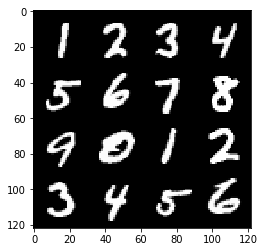

In [14]:
# visualize the original images of the last batch of the test set
img = make_grid(img, nrow=4, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
show(img)

torch.Size([16, 1, 28, 28])


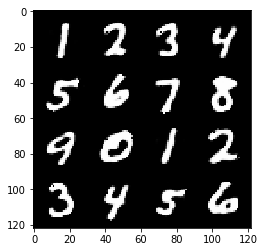

In [15]:
# visualize the reconstructed images of the last batch of test set
recon_batch_denorm = denorm(recon_batch.view(-1, 1, 28, 28).cpu())
print(recon_batch_denorm.size())
recon_batch_denorm = make_grid(recon_batch_denorm, nrow=4, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
show(recon_batch_denorm)

## Variational Autoencoders

In [9]:
transform = transforms.Compose([
     transforms.ToTensor(),lambda x: x>0.5, lambda x: x.type(torch.FloatTensor)
])

denorm = denorm_for_binary

# transform = transforms.Compose([
#      transforms.ToTensor()
# ])

# denorm = denorm_for_sigmoid
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

### Hyper-parameter selection

In [10]:
if not os.path.exists('./VAE'):
    os.mkdir('./VAE')
    
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
latent_dim = 32
intermediate_dim = 256

### Define the data loaders

In [11]:
train_loader = DataLoader(train_dat, batch_size, shuffle=True)
test_loader = DataLoader(test_dat, batch_size, shuffle=False)

it = iter(test_loader)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[:32, :, :, :]

in_dim = fixed_input.shape[-1]*fixed_input.shape[-2]

save_image(fixed_input, './VAE/image_original.png')

## Define the model

### Reminder

We want to maximize the probability of our training data under the parameters of our model:

So, for a data sample $x_i$

$ \log{p(x_i;\theta)} = ... = \log{p(x_i|z_i;\theta)} - D_{KL}(q_\phi(z_i|x_i)\|p_\theta(z_i)) + D_{KL}(q_\phi(z_i|x_i)\|p_\theta(z_i|x_i)) \geq \log{p(x_i|z_i;\theta)} - D_{KL}(q_\phi(z_i|x_i)\|p_\theta(z_i)) $

And for the entire dataset:
$ \log{\mathbb{P}[X;\theta]} = \sum_i{\log{p(x_i;\theta)}} \geq \sum_i{\log{p(x_i|z_i;\theta)} - D_{KL}(q_\phi(z_i|x_i)\|p_\theta(z_i))} $

* First term: 

**If continuous variables**:

Under gaussianity assumptions, The probabilistic decoder predicts the mean and the variance of the gaussian.

 $\sum_i\log{p(x_i|z_i;\theta)}=\sum_i\log{\mathcal{N}(\mu_i,\sigma_i^2I)}= 
\sum_i(-\frac{\|x_i-\mu_i\|_2^2}{2\sigma_i^2} - \frac{1}{2}\log{|2\pi \sigma_i^2I|})$

Usually we omit the prediction of the variance and predict only the mean. Thus, we are minimizing:

$\sum_i\|x_i-\mu_i\|_2^2 = \sum_i\|x_i-f(z_i)\|_2^2$ : **Mean squared error**


**If  binary variables**:

Under bernoulli assumptions, the probabilistic decoder predicts the probability of a sample being equal to 1.

$\sum_i\log{p(x_i|z_i;\theta)}=\sum_i\log{\mathcal{Be}(f(z_i))}= $. Thus, we are minimizing:

$\sum_i(x_i\log{f(z_i)}+(1-x_i)\log{(1-f(z_i))})$, where $x\in\{0,1\}$ : **Binary cross entropy**

* Second term: if $  z_i\sim\mathcal{N}(0,I) $, then:

$$ - D_{KL}(q_\phi(z_i|x_i)\|p_\theta(z_i)) = \frac{1}{2}\sum_{j=1}^J{(1+log(\sigma_j^2)-\mu_j^2+\sigma_j^2)} $$, where $J$ the dimensionality of the latent space

(prove it for homework!)

1. **Encoder**:
Input $\rightarrow$ Hidden Layers $\rightarrow$ $\mu_j,  \log(\sigma_j^2) = 2\log(\sigma_j) \, , \forall j$ 
2. **Decoder**:
$\mu_j, \log(\sigma_j^2) \rightarrow$ **Sample**: $z_j = \epsilon_j * \sigma_j+\mu_j = \epsilon * e^{\frac{1}{2}\log(\sigma_j^2)}+\mu_j \rightarrow$  Hidden Layers $ \rightarrow$Output

In [12]:
class VAE_three(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, latent_dim):
        super(VAE_three, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc_mu = nn.Linear(h_dim2, latent_dim)
        self.fc_std = nn.Linear(h_dim2, latent_dim)
        # decoder part
        self.fc4 = nn.Linear(latent_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_std(h)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps*std+mu
        return z
        
    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        out = F.sigmoid(self.fc6(h)) 
        return out
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar
    
# single-layer model

class VAE_single(nn.Module): 
    def __init__(self, in_dim = 784, latent_dim =32):
        super(VAE_single, self).__init__()

        # Encoder
        self.fc_mu = nn.Linear(in_dim, latent_dim)
        self.fc_std = nn.Linear(in_dim, latent_dim)
        
        self.fc1 = nn.Linear(latent_dim, in_dim)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_std(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps*std + mu
        return z

    def decode(self, z):
        out = self.sigmoid(self.fc1(z))
        return out
 
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [13]:
single_layer_VAE = VAE_single(in_dim = in_dim, latent_dim =latent_dim)
three_layer_VAE = VAE_three(x_dim=in_dim, h_dim1= 2*intermediate_dim, h_dim2=intermediate_dim, latent_dim=2)

### Define loss function

In [14]:

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_VAE(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Initialize model and print number of parameters

In [17]:
# model = single_layer_VAE.to(device)
model = three_layer_VAE.to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params)) 
print(model)

Total number of parameters is: 1068820
VAE_three(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_std): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


### Choose and initialize optimizer

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [19]:
model.train()
n_samples = 32
z = torch.randn(n_samples,2).to(device)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        img= img.view(img.size(0), -1)
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch, mu, logvar = model(img)
        loss = loss_function_VAE(recon_batch, img, mu, logvar)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader.dataset)))
    recon,_,_ = model(fixed_input.view(fixed_input.size(0), -1).to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './VAE/reconstructed_epoch_{}.png'.format(epoch))
    
    samples = model.decode(z)
    save_image(denorm(samples).cpu(), './VAE/samples_epoch_{}.png'.format(epoch),nrow = 8)

# save the model
torch.save(model.state_dict(), './VAE/model.pth')

/home/gbouritsas/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/gbouritsas/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch [1/10], loss:179.5999
epoch [2/10], loss:154.4242
epoch [3/10], loss:148.5536
epoch [4/10], loss:145.3124
epoch [5/10], loss:142.8663
epoch [6/10], loss:141.0534
epoch [7/10], loss:139.7591
epoch [8/10], loss:138.6317
epoch [9/10], loss:137.6838
epoch [10/10], loss:136.8005


### Test

In [20]:
model.load_state_dict(torch.load("./VAE/model.pth"))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        recon_batch, mu, logvar = model(img)
        test_loss += loss_function_VAE(recon_batch, img, mu, logvar)
        img = denorm(img.cpu())
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 138.3421


### Visualizations

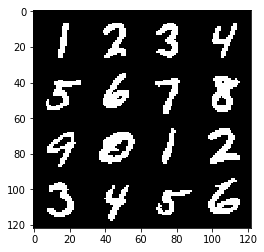

In [21]:
# visualize the original images of the last batch of the test set
img = make_grid(img.type(torch.FloatTensor), nrow=4, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
show(img)

torch.Size([16, 1, 28, 28])


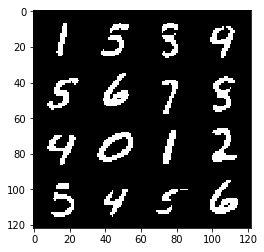

In [22]:
# visualize the reconstructed images of the last batch of test set
recon_batch_denorm = denorm(recon_batch.view(-1, 1, 28, 28).cpu())
print(recon_batch_denorm.size())
recon_batch_denorm = make_grid(recon_batch_denorm.type(torch.FloatTensor), nrow=4, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
show(recon_batch_denorm)

## Sample

In [28]:
model.load_state_dict(torch.load("./VAE/model.pth"))
model.eval()
n_samples = 32
with torch.no_grad():
    z = torch.sort(torch.randn(n_samples,1),dim=0)[0].to(device)
    gridz1, gridz2 = torch.meshgrid(torch.squeeze(z),torch.squeeze(z))
    gridz1 = gridz1.contiguous().view(-1,1)
    gridz2 = gridz2.contiguous().view(-1,1)
    gridz = torch.cat((gridz1,gridz2),1)
    samples = model.decode(gridz)
    save_image(denorm(samples).type(torch.FloatTensor).cpu(), './VAE/samples' + '.png',nrow = n_samples)
